In [1]:
import torch as nn 
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from tqdm import trange
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt 
%matplotlib inline


In [2]:
trainX = nn.load( "trainX.pt" )
trainy = nn.load( "trainy.pt" )
testX = nn.load( "testX.pt" )
testy = nn.load( "testy.pt" )

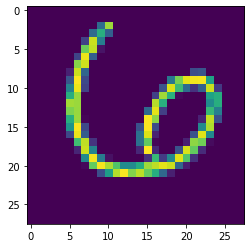

tensor(6)


In [14]:
plt.imshow( trainX[2].view(28, 28) )
plt.show()

print( trainy[2] )

In [4]:
class Net( Module ):
    def __init__( self ):
        #init super class
        super(Net, self).__init__()
        
        #define conv layer arch
        self.conv1 = Conv2d(1, 32, 2)
        self.conv2 = Conv2d(32, 64, 2)
        self.conv3 = Conv2d(64, 128, 2)
        
        #1-step forwrd prop for conv output shape
        t = nn.randn( 28,28 ).view( -1, 1, 28, 28 )
        self._linear_shape = None
        self.conv_pipe( t )
        
        print( self._linear_shape )
        
        #fully-connected layers
        self.fc1 = Linear( self._linear_shape, 512 )
        self.fc2 = Linear( 512, 10 )
        
    def conv_pipe(self, x):
        #first conv layer with an activation function and pooling
        x = self.conv1( x )
        x = F.relu( x )
        x = F.max_pool2d( x, (2, 2) )
        
        #second conv layer with an activation function and pooling
        x = self.conv2( x )
        x = F.relu( x )
        x = F.max_pool2d( x, (2, 2) )
        
        #third conv layer with an activation function and pooling
        x = self.conv3( x )
        x = F.relu( x )
        x = F.max_pool2d( x, (2, 2) )
        
        #forward pass to get shape of the flattened conv layer,
        #only runs once when class instantiated
        if self._linear_shape is None:
            shape = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            self._linear_shape = shape
            
        return x
    
    def forward( self, x ):
        #conv layers
        x = self.conv_pipe( x )
        
        #shape
        x = x.view( -1, self._linear_shape )
        
        #linear layers
        x = F.relu( self.fc1( x ) )
        x = self.fc2( x )
        
        #activated output classications
        #loss wasn't changing until I changed this.
        return F.log_softmax( x, dim=1)
    
model = Net().float()    
        

512


In [15]:
optimizer = Adam( model.parameters(), lr=0.001 )
lossF = CrossEntropyLoss() 
BATCH_SIZE = 32
EPOCHS = 4

loss_history = []
accuracy_history = []

for epoch in range(EPOCHS): 
    for i in trange( 0, len(trainX), BATCH_SIZE ):
        #X and ygt of batch
        bX = trainX[i:i+BATCH_SIZE].view(-1, 1, 28, 28)
        by = trainy[i:i+BATCH_SIZE]
        
        #train model, calculate loss
        model.zero_grad()
        outputs = model( bX.float() )
        loss = F.nll_loss( outputs, by )
        
        #store loss
        loss_history.append( loss )
        
        #backward step
        loss.backward()
        optimizer.step()

100%|██████████| 1969/1969 [00:35<00:00, 55.22it/s]


In [16]:
with nn.no_grad():
    output = model( testX.view(-1, 1, 28, 28).float() )
    
sf = nn.exp( output )
prob = list( sf.numpy() )
predictions = np.argmax(prob, axis=1)

accuracy_score( testy, predictions )

0.9775714285714285

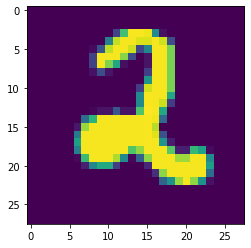

2


In [19]:
ind = np.random.randint( 0, len(testX) )

plt.imshow( testX[ind].view(28, 28))
plt.show()

print( predictions[ind] )